In [24]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import sklearn.neural_network
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import lime.lime_tabular_mod
import matplotlib.pyplot as plt
import doc.mod.utils.DatasetRepository as dr
from tqdm import tqdm

import importlib
importlib.reload(lime.lime_tabular_mod)
repo = dr.DatasetRepository("../data")


pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load datasets

In [2]:
for dataset in repo.get_all_datasets():
    print(dataset.name)

titanic
fetal health
wines
mushrooms
heart disease


In [3]:
sample_dataset = repo.get_titanic_dataset()
sample_dataset.train_data

,Pclass,Sex,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,embarked_unknown,cabin_level_A,cabin_level_B,cabin_level_C,cabin_level_D,cabin_level_E,cabin_level_F,cabin_level_G,cabin_level_T,cabin_level_unknown
PassengerId,,,,,,,,,,,,,,,,,,,
144,3,1,19.000000,0,0,6.7500,0,1,0,0,0,0,0,0,0,0,0,0,1
777,3,1,29.699118,0,0,7.7500,0,1,0,0,0,0,0,0,0,1,0,0,0
842,2,1,16.000000,0,0,10.5000,0,0,1,0,0,0,0,0,0,0,0,0,1
240,2,1,33.000000,0,0,12.2750,0,0,1,0,0,0,0,0,0,0,0,0,1
681,3,0,29.699118,0,0,8.1375,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,1,1,0.920000,1,2,151.5500,0,0,1,0,0,0,1,0,0,0,0,0,0
564,3,1,29.699118,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0,0,1
818,2,1,31.000000,1,1,37.0042,1,0,0,0,0,0,0,0,0,0,0,0,1


## Check performance of different classifiers on selected dataset (with their default settings)

In [4]:
models = [
    ("Random Forest", sklearn.ensemble.RandomForestClassifier(n_jobs=-1)),
    ("AdaBoost", sklearn.ensemble.AdaBoostClassifier()),
    ("DecisionTree", sklearn.tree.DecisionTreeClassifier()),
    ("Neural Network", sklearn.neural_network.MLPClassifier()),
    ("SVM", sklearn.svm.LinearSVC()),
    ("Naive Bayes", sklearn.naive_bayes.GaussianNB()),
    ("kNN", sklearn.neighbors.KNeighborsClassifier())
]
precision_for_classifier = {}
recall_for_classifier = {}
f1_for_classifier = {}
for (classifier_name, model) in models:
    x = sample_dataset.train_data.to_numpy()
    y = sample_dataset.train_labels.to_numpy()
    model.fit(x, y)

    x = sample_dataset.test_data.to_numpy()
    y_true = sample_dataset.test_labels.to_numpy()
    y_predicted = model.predict(x)

    precision_for_classifier[classifier_name] = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_predicted, average="macro")
    recall_for_classifier[classifier_name] = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_predicted, average="macro")
    f1_for_classifier[classifier_name] = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_predicted, average="macro")

c:\users\kamil zych\documents\mgr\lime\venv\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


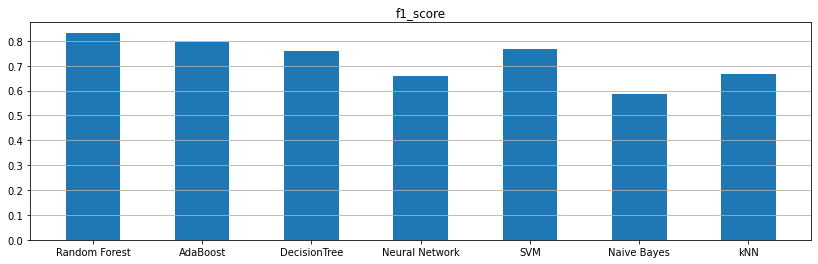

In [5]:
plt.figure(figsize=(14,4))
plt.bar(f1_for_classifier.keys(), f1_for_classifier.values(), width=0.5)
plt.title("f1_score")
plt.grid(axis="y")
plt.show()

## Use LIME to explain prediction
### Create explainer object
At first create explainer object that makes use of training data.
It may be used by discretizer inner object and enhance local surrogate's performance.

In [6]:
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    sample_dataset.train_data.to_numpy(),
    feature_names = sample_dataset.train_data.columns.to_list(),
    class_names = sample_dataset.train_labels.drop_duplicates().to_list(),
    discretize_continuous=False,
    sample_around_instance=True,
    categorical_features=sample_dataset.categorical_features
)

In [30]:
test_data_subset = sample_dataset.test_data.to_numpy()
fidelity_loss_on_explanation = []
fidelity_loss_on_generated_data = []
fidelity_loss_distribution_quantiles = []

for test_instance in tqdm(test_data_subset):
    explanation = explainer.explain_instance(
        test_instance.reshape(-1),
        model.predict_proba,
        num_features = 4,
        top_labels = 2,
        distance_metric="minkowski",
        minkowski_norm=100.
    )

    fidelity_loss_on_explanation.append(explanation.get_fidelity_loss_on_explanation())
    fidelity_loss_on_generated_data.append(explanation.get_fidelity_loss_on_generated_data())
    fidelity_loss_distribution_quantiles.append(explanation.get_fidelity_loss_distribution(quantiles=30))

100%|██████████| 90/90 [01:24<00:00,  1.06it/s]


0.08159122763413916


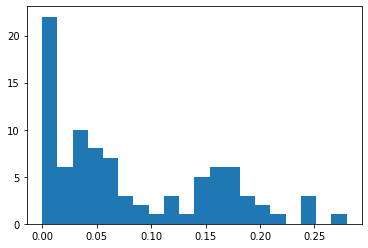

In [35]:
print(np.mean(fidelity_loss_on_explanation))
plt.hist(fidelity_loss_on_explanation, bins=20)
plt.show()

0.06145542029696509


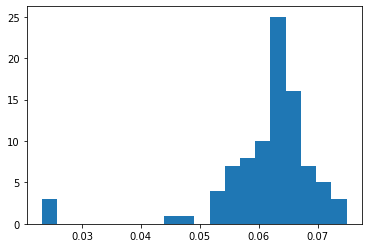

In [36]:
print(np.mean(fidelity_loss_on_generated_data))
plt.hist(fidelity_loss_on_generated_data, bins=20)
plt.show()

c:\users\kamil zych\documents\mgr\lime\venv\lib\site-packages\matplotlib\axes\_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


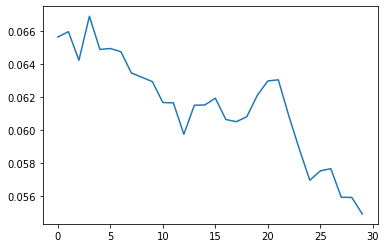

In [39]:
merged_distributions = pd.concat(fidelity_loss_distribution_quantiles, axis=1)
plt.plot(merged_distributions.mean(axis=1))
